# Numerical Imaging Project - Haze removal

## Thomas Chabal & Martin Graive

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from time import time

from utils import load_image, show_imgs

## Haze removal implementation

In [49]:
def extract_dark_channel(img, A, patch_size=PATCH_SIZE):
    start = time()
    min_per_patch_and_channel = np.zeros(img.shape)
    
    patch_side_size = patch_size // 2
    for x in tqdm(range(img.shape[0])):
        for y in range(img.shape[1]):
            min_x, max_x = max(0, x - patch_side_size), min(x + patch_side_size, img.shape[0])
            min_y, max_y = max(0, y - patch_side_size), min(y + patch_side_size, img.shape[1])
            for c in range(img.shape[2]):
                min_per_patch_and_channel[x, y, c] = np.min(img[min_x:max_x, min_y:max_y, c]) / A[c]
    
    print("Took {:2f}s to compute dark channel".format(time() - start))
    return np.min(min_per_patch_and_channel, axis=2)

In [50]:
def compute_atmospheric_light(image, dark_channel):
    sorted_darkness = np.sort(dark_channel).flatten()
    values_to_keep = int(0.1 / 100 * sorted_darkness.shape[0])
    top_brightest_dark_channel = sorted_darkness[:values_to_keep]
    keep_dark_channel = np.where(dark_channel >= np.min(top_brightest_dark_channel), 1, 0)
    
    maximum_intensity = 0
    atmospheric_light = None
    for x in tqdm(range(image.shape[0])):
        for y in range(image.shape[1]):
            if keep_dark_channel[x, y]:
                pixel = image[x, y, :]
                intensity = np.linalg.norm(pixel)
                if intensity >= maximum_intensity:
                    maximum_intensity = intensity
                    atmospheric_light = pixel

    return atmospheric_light

In [34]:
def compute_transmission(image, A, omega=OMEGA):
    dark_channel = extract_dark_channel(image, A)
    return 1 - omega * dark_channel

## ADD SOFT MATTING AND GUIDED FILTERING

In [59]:
def compute_radiance(image, A, transmission, t0=T0):
    start = time()
    
    transmission_bounded = np.where(transmission >= t0, transmission, t0)
    radiance = np.zeros(image.shape)
    
    for x in tqdm(range(image.shape[0])):
        for y in range(image.shape[1]):
            radiance[x, y] = (image[x, y] - A) / transmission_bounded[x, y] + A
            
    print("Took {:2f}s to compute radiance".format(time() - start))
    return radiance

In [64]:
def remove_haze(image):
    start = time()
    
    print("Extracting dark channel...")
    dark_channel = extract_dark_channel(image, np.array([1.0, 1.0, 1.0]))

    print("Computing atmospheric light...")
    A = compute_atmospheric_light(image, dark_channel)

    print("Computing transmission...")
    transmission = compute_transmission(image, A)

    print("Computing radiance...")
    radiance = compute_radiance(image, A, transmission)
    
    print("Took {:2f}s to perform haze removal".format(time() - start))
    return radiance, transmission, A

## Experiments

In [31]:
## CONSTANTS OF THE PROBLEM
OMEGA = 0.95
PATCH_SIZE = 5
T0 = 0.1

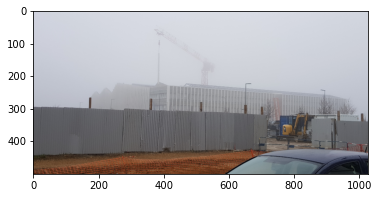

In [32]:
img_path = './Project/images/20210127_142511.jpg'
HEIGHT = 500

image = load_image(img_path, HEIGHT)

In [65]:
#print("Extracting dark channel...")
#dark_channel = extract_dark_channel(image, np.array([1.0, 1.0, 1.0]))

#print("Computing atmospheric light...")
#A = compute_atmospheric_light(image, dark_channel)

#print("Computing transmission...")
#transmission = compute_transmission(image, A)

#print("Computing radiance...")
#radiance = compute_radiance(image, A, transmission)

radiance, transmission, A = remove_haze(image)

  2%|▏         | 10/500 [00:00<00:11, 43.21it/s]

Extracting dark channel...


  4%|▍         | 21/500 [00:00<00:02, 204.32it/s]

Took 11.656326s to compute dark channel
Computing atmospheric light...


  1%|          | 5/500 [00:00<00:11, 42.59it/s]

Computing transmission...


  6%|▋         | 32/500 [00:00<00:01, 316.90it/s]

Took 11.732989s to compute dark channel
Computing radiance...


100%|██████████| 500/500 [00:02<00:00, 242.64it/s]

Took 2.064699s to compute radiance
Took 26.113218s to perform haze removal


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


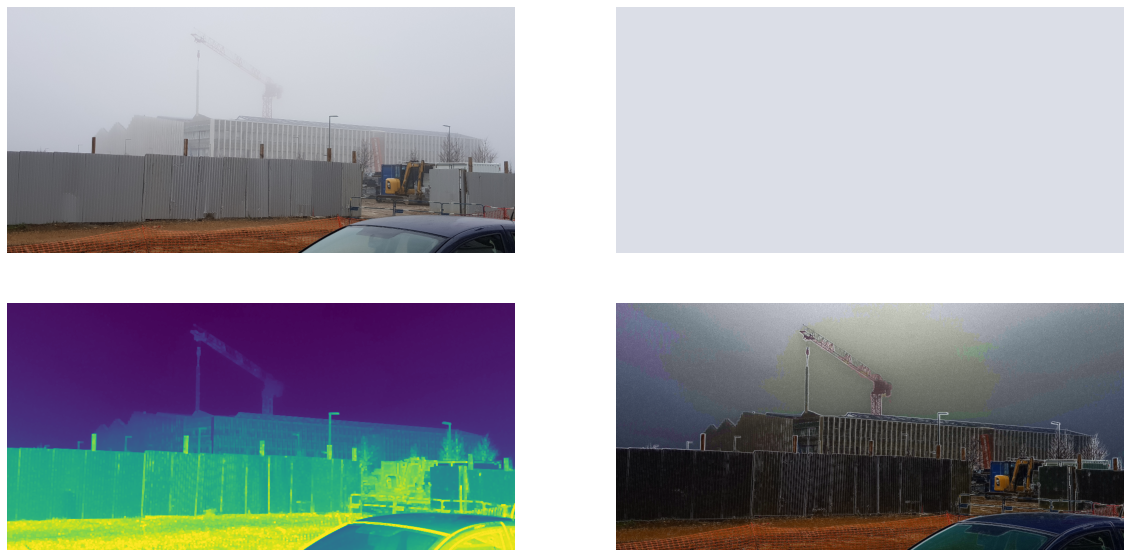

In [66]:
show_imgs([image, np.ones_like(image) * A, transmission, radiance], figsize=(20,10))